# Ramp4 with all sensors' data

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


## 0. Helper functions

In [2]:
def read_data_from_single_file(filepath):
    """Read in quench data from a given file, return a pandas dafa frame"""
    
    data_dict= {}
    
    with open(filepath) as f:
        content = f.readlines()
    #Remove`\n` at the end of each line
    content = [x.strip() for x in content]
    
    column_names = content[0].split(" ")
    data = [content[i].split("   ") for i in range(1, len(content))] 
    
    for i in range(len(column_names)):
        data_dict[column_names[i]] = [float(x[i]) for x in data]
        
    data_frame = pd.DataFrame(data_dict)
    
    return data_frame

def read_quench_data(area_path, quench_name):
    """
    Read the quench data from the provided file path, note that there are five quenches so we need to concatenate them together.
    Just need to provide the quench's name, for e.g: "./data/mqxfs1b.Quench.161011115654"
    """
    
    data_list = []
    
    
    num_file = 0 #Number of separate data files for this quench, assuming at least one
    
    for filename in os.listdir(area_path):
        if filename.startswith(quench_name) and not filename.endswith(".tar.gz"):
            #print("Reading file ... " + filename)
            if num_file == 0:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename)) #read first file separately
                except:
                    pass
            else:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename).drop(columns = ["time"])) #Time is already saved in the first file
                except:
                    pass
            num_file += 1
                                 
    #print("Total number of data files for {}: ".format(quench_name), num_file)
    
    if len(data_list) != 0:
        data = pd.concat(data_list, axis = 1) #Concatenate all data files together
        return data
    else:
        print("Returning None due to file errors in " + quench_name)
        return None

def read_all_quench_in_area(area_path):
    """
    Read all quench's files in the area and return a dictionary of different quench's data. name is the magnet's name
    """
    data = {}
    
    index = 1 #For indexing different quench

    for filename in os.listdir(area_path):
        if filename.endswith(".tar.gz"): 
            #print("Reading data from ... " + filename[0:-7])
            data[filename[0:-7]] = read_quench_data(area_path, filename[0:-7])
            index += 1
            
    #print("Completed. There are {} quenches in total.".format(str(index - 1)))
    
    return data

def plot_variables_with_time(data, variables = None, time_range = None):
    """
    Take a data frame, and plot all other variables with time.
    Optional argument: time_range to specify the range to plot, default is to plot all time. Example argument
    is (start_time, end_time)
    """
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    if variables:
        for variable in variables:
            plt.figure(figsize=(20,2))
            plt.plot(data["time"], data[variable])
            plt.xlabel("Time (s)")
            plt.title("Variable {}".format(variable))
            plt.show()
        
    else:      
        #If variables not specified then just plot all 
        for variable in data.columns[1:]:
            plt.figure(figsize=(25,2))
            plt.plot(data["time"], data[variable])
            plt.xlabel("Time (s)")
            plt.title("Variable {}".format(variable))
            plt.show()

def plot_statistics(data, variables = None, time_range = None, window = 100):
    """Take a data frame and plot the variable with its moving average and real data in the specified range, if
    variables are not specified then just plot all variables by default"""
    #Pickout the data
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    def plot_signal_and_statistics(variable):
        # Plotted by calculating Simple Moving Average (SMA)
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data[variable], label = "Signal with noise")
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).mean(),label = "Moving average")
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).min(),label = "Moving min")
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).max(),label = "Moving max")
        plt.legend(loc = "best")
        plt.xlabel("Time (s)")
        plt.title("Variable {}".format(variable))
        plt.show()
        
        
        #Variance
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).std(),
                 label = "Variance",
                 color = 'red')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Variance".format(variable))
        plt.show()
        
        #Kurtosis
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).kurt(),
                 label = "Kurtosis",
                 color = 'green')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Kurtosis".format(variable))
        plt.show()
        
        #Skew
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).skew(),
                 label = "Skew",
                 color = 'purple')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Skew".format(variable))
        plt.show()
        
        """
        #Quantile
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.25), label = "Quantile 25",
                 color = 'red')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.75), label = "Quantile 75",
                 color = 'orange')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.50), label = "Quantile 50",
                 color = 'green')
        plt.legend(loc = "best")
        plt.title("Variable {}'s Quantile".format(variable))
        plt.show()
        """
        
    #Plot
    if variables:
        for variable in variables:
            print(variable)
            plot_signal_and_statistics(variable)         
    else:
        for variable in data.columns[1:]:
            print(variable)
            plot_signal_and_statistics(variable)
    
    %reset -f in

def plot_variable(data_dict, variable, time_range = None, window = 100):
    for quench_name in data_dict.keys():
        print("Quench's index: " + quench_name)
        if data_dict[quench_name] is not None:
            if variable[0] in list(data_dict[quench_name].columns):
                plot_statistics(data_dict[quench_name], variables = variable, time_range=time_range, window=window)

In [3]:
def read_data_from_single_file(filepath):
    """Read in quench data from a given file, return a pandas dafa frame"""
    
    data_dict= {}
    
    with open(filepath) as f:
        content = f.readlines()
    #Remove`\n` at the end of each line
    content = [x.strip() for x in content]
    
    column_names = content[0].split(" ")
    data = [content[i].split("   ") for i in range(1, len(content))] 
    
    for i in range(len(column_names)):
        data_dict[column_names[i]] = [float(x[i]) for x in data]
        
    data_frame = pd.DataFrame(data_dict)
    
    return data_frame

def read_quench_data(area_path, quench_name):
    """
    Read the quench data from the provided file path, note that there are five quenches so we need to concatenate them together.
    Just need to provide the quench's name, for e.g: "./data/mqxfs1b.Quench.161011115654"
    """
    
    data_list = []
    
    
    num_file = 0 #Number of separate data files for this quench, assuming at least one
    
    for filename in os.listdir(area_path):
        if filename.startswith(quench_name) and not filename.endswith(".tar.gz"):
            #print("Reading file ... " + filename)
            if num_file == 0:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename)) #read first file separately
                except:
                    pass
            else:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename).drop(columns = ["time"])) #Time is already saved in the first file
                except:
                    pass
            num_file += 1
                                 
    #print("Total number of data files for {}: ".format(quench_name), num_file)
    
    if len(data_list) != 0:
        data = pd.concat(data_list, axis = 1) #Concatenate all data files together
        return data
    else:
        print("Returning None due to file errors in " + quench_name)
        return None

def read_all_quench_in_area(area_path):
    """
    Read all quench's files in the area and return a dictionary of different quench's data. name is the magnet's name
    """
    data = {}
    
    index = 1 #For indexing different quench

    for filename in os.listdir(area_path):
        if filename.endswith(".tar.gz"): 
            #print("Reading data from ... " + filename[0:-7])
            data[filename[0:-7]] = read_quench_data(area_path, filename[0:-7])
            index += 1
            
    #print("Completed. There are {} quenches in total.".format(str(index - 1)))
    
    return data

def plot_variables_with_time(data, variables = None, time_range = None):
    """
    Take a data frame, and plot all other variables with time.
    Optional argument: time_range to specify the range to plot, default is to plot all time. Example argument
    is (start_time, end_time)
    """
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    if variables:
        for variable in variables:
            plt.figure(figsize=(20,2))
            plt.plot(data["time"], data[variable])
            plt.xlabel("Time (s)")
            plt.title("Variable {}".format(variable))
            plt.show()
        
    else:      
        #If variables not specified then just plot all 
        for variable in data.columns[1:]:
            plt.figure(figsize=(25,2))
            plt.plot(data["time"], data[variable])
            plt.xlabel("Time (s)")
            plt.title("Variable {}".format(variable))
            plt.show()

def plot_statistics(data, variables = None, time_range = None, window = 100):
    """Take a data frame and plot the variable with its moving average and real data in the specified range, if
    variables are not specified then just plot all variables by default"""
    #Pickout the data
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    def plot_signal_and_statistics(variable):
        # Plotted by calculating Simple Moving Average (SMA)
        plt.figure(figsize=(20,2))
        
        plt.plot(data["time"], data[variable], label = "Signal with noise")
        
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).mean(),label = "Moving average")
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).min(),label = "Moving min")
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).max(),label = "Moving max")
        plt.legend(loc = "best")
        plt.xlabel("Time (s)")
        plt.title("Variable {}".format(variable))
        plt.show()
        

        #Variance
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).std(),
                 label = "Standard Deviation",
                 color = 'red')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Standard Deviation".format(variable))
        plt.show()
        
        #Kurtosis
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).kurt(),
                 label = "Kurtosis",
                 color = 'green')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Kurtosis".format(variable))
        plt.show()
        
        #Skew
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).skew(),
                 label = "Skew",
                 color = 'purple')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Skew".format(variable))
        plt.show()
        
        """
        #Quantile
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.25), label = "Quantile 25",
                 color = 'red')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.75), label = "Quantile 75",
                 color = 'orange')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.50), label = "Quantile 50",
                 color = 'green')
        plt.legend(loc = "best")
        plt.title("Variable {}'s Quantile".format(variable))
        plt.show()
        """
        
    #Plot
    if variables:
        for variable in variables:
            print(variable)
            plot_signal_and_statistics(variable)         
    else:
        for variable in data.columns[1:]:
            print(variable)
            plot_signal_and_statistics(variable)
    
    %reset -f in

def plot_variable(data_dict, variable, time_range = None, window = 100):
    for quench_name in data_dict.keys():
        print("Quench's index: " + quench_name)
        if data_dict[quench_name] is not None:
            if variable[0] in list(data_dict[quench_name].columns):
                plot_statistics(data_dict[quench_name], variables = variable, time_range=time_range, window=window)


########### PROCESS RAMPING DATA ###############
def read_tdms_file(filepath):
    """Read the tdms file from a given path, return a pandas data frame of the tdms file"""
    tdms_file = TdmsFile.read(data_path)
    
    data_frame = tdms_file.as_dataframe()
    
    del tdms_file
    
    #Just the last 3 symbols in columns name matter ('/'_unnamedTask<3>'/'PXI2Slot14/ai0') -> ai0
    #Rename the columns
    rename_map = []
    
    for column in data_frame.columns:
        rename_map.append(column[-4:-1])
    
    data_frame.columns = rename_map
    
    #Add time axis relative to the time when quench happens
    time_range = np.asarray(range(data_frame.shape[0]))
    

    #Center around the max value (quench happens at 0 time)
    max_index = data_frame['ai7'].idxmax()
    time_range -= max_index
    time_range = time_range.astype('float32')
    
    #Multiply by datarate
    time_range = np.multiply(time_range, 1e-5, out=time_range, casting="unsafe")
    
    data_frame['time'] = time_range
    
    return data_frame

def break_tdms_to_files(file_path):
    """Read the tdms file and break it into several files according to channels in a new directory"""
    tdms_file = TdmsFile.read(file_path)
    
    data_frame = tdms_file.as_dataframe()
    
    del tdms_file
    
    os.mkdir("./data/" + file_path[-10:-5])
    
    for channel in data_frame.columns:
        np.save("./data/{}/{}".format(file_path[-10:-5], channel[-4:-1]), data_frame.loc[:, channel].to_numpy())

def calculate_time(dir_path):
    """Take a tdms file directory path (after the file is broken up), and calculate and output a time file."""
    
    ai7 = np.load(dir_path + "ai7.npy")
    
    #Add time axis relative to the time when quench happens
    time_range = np.asarray(range(ai7.shape[0]))
    
    #Center around the max value (quench happens at 0 time)
    max_index = np.argmax(ai7)
    time_range -= max_index
    time_range = time_range.astype('float32')
    
    #Multiply by datarate
    time_range = np.multiply(time_range, 1e-5, out=time_range, casting="unsafe")
    
    np.save(dir_path + "time", time_range)

def load_channel_and_time(dir_path, channel):
    data_frame = pd.DataFrame(data = {channel: np.load(dir_path + channel + ".npy"),
                                     "time": np.load(dir_path + "time.npy")})
    return data_frame

def plot_channel(data, channel, time_range = None):
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data[channel])
    plt.title("Variable {}".format(channel))
    plt.show()
    
    %reset -f in

def load_and_plot(dir_path, channel, time_range = None, stat = False, window = 100):
    ai = load_channel_and_time(dir_path, channel)
    
    if stat:
        plot_statistics(ai, variables = [channel], time_range = time_range, window = window)
    else:
        plot_channel(ai, channel, time_range = time_range)
    
    %reset -f in

In [4]:
def generate_data(dir_path, channel, time_range, window = 1000, step = 10):
    #Load the data
    data = load_channel_and_time(dir_path, channel)
    
    #Select the part
    start = time_range[0]
    end = time_range[1]
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Calculate the statistics
    #data["Mean"] = data.loc[:, channel].rolling(window=window).mean()
    data["SD"] = data.loc[:, channel].rolling(window=window).std()
    data["Kurtosis"] = data.loc[:, channel].rolling(window=window).kurt()
    data["Skew"] = data.loc[:, channel].rolling(window=window).skew()
    
    select_list = [channel, "SD", "Kurtosis", "Skew"]
    
    assert data[select_list].to_numpy()[window-1::step].shape[0] == data['time'].to_numpy()[window-1::step].shape[0]
    
    %reset -f in
    
    return data[select_list].to_numpy()[window-1::step], data['time'].to_numpy()[window-1::step]

def generate_data_no_time(dir_path, channel, time_range, window = 1000, step = 10):
    #Load the data
    data = load_channel_and_time(dir_path, channel)
    
    #Select the part
    start = time_range[0]
    end = time_range[1]
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Calculate the statistics
    #data["Mean"] = data.loc[:, channel].rolling(window=window).mean()
    data["SD"] = data.loc[:, channel].rolling(window=window).std()
    data["Kurtosis"] = data.loc[:, channel].rolling(window=window).kurt()
    data["Skew"] = data.loc[:, channel].rolling(window=window).skew()
    
    select_list = [channel, "SD", "Kurtosis", "Skew"]
    
    %reset -f in
    
    return data[select_list].to_numpy()[window-1::step]

def generate_data_all_sensors(dir_path, time_range, window = 1000, step = 10):
    
    ai0, time = generate_data(dir_path, "ai0", time_range = time_range, window = window, step = step)
    ai1 = generate_data_no_time(dir_path, "ai1", time_range = time_range, window = window, step = step)
    ai2 = generate_data_no_time(dir_path, "ai2", time_range = time_range, window = window, step = step)
    ai3 = generate_data_no_time(dir_path, "ai3", time_range = time_range, window = window, step = step)
    ai4 = generate_data_no_time(dir_path, "ai4", time_range = time_range, window = window, step = step)
    
    all_channels = np.concatenate((ai0,ai1,ai2,ai3,ai4), axis = 1)
    
    %reset -f in
    
    return all_channels, time

## 1.1 Window size: 10ms; step = 100us

In [7]:
X_train, train_time = generate_data_all_sensors("./data/Ramp4/", time_range = (-450, -350), window = 1000, step = 10)
X_test, test_time = generate_data_all_sensors("./data/Ramp4/", time_range = (-20, 0), window = 1000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (999900, 20)
X_test's shape:  (199900, 20)


In [8]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(15, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(10,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(7,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(15,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 15)                165       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                320       
Total params: 1,117
Trainable params: 1,117
Non-trainable params: 0
________________________

In [9]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=2000

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 899910 samples, validate on 99990 samples
Epoch 1/50
899910/899910 [==============================] - 8s 9us/step - loss: 3.7211 - val_loss: 0.3336
Epoch 2/50
899910/899910 [==============================] - 7s 8us/step - loss: 0.1279 - val_loss: 0.0568
Epoch 3/50
899910/899910 [==============================] - 7s 8us/step - loss: 0.0406 - val_loss: 0.0454
Epoch 4/50
899910/899910 [==============================] - 7s 8us/step - loss: 0.0336 - val_loss: 0.0401
Epoch 5/50
899910/899910 [==============================] - 7s 7us/step - loss: 0.0305 - val_loss: 0.0367
Epoch 6/50
899910/899910 [==============================] - 7s 8us/step - loss: 0.0276 - val_loss: 0.0334
Epoch 7/50
899910/899910 [==============================] - 7s 8us/step - loss: 0.0238 - val_loss: 0.0310
Epoch 8/50
899910/899910 [==============================] - 6s 7us/step - loss: 0.0201 - val_loss: 0.0298
Epoch 9/50
899910/899910 [==============================] - 7s 8us/step - loss: 0.0178 - val_loss: 0.

In [19]:
model.save("./models/All-Ramp4-10mswin-100usstep.h5")

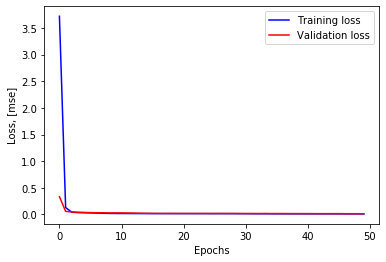

In [10]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

In [11]:
X_pred = model.predict(np.array(X_train))
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

Text(0.5, 0, 'Time (s)')

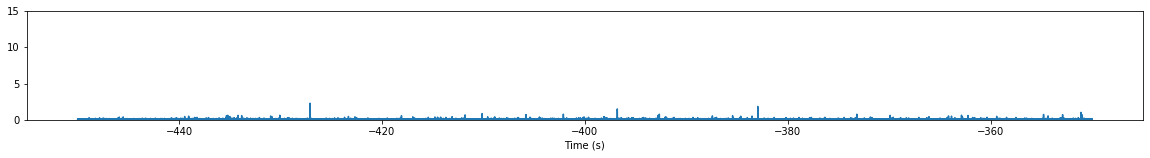

In [15]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0,15])
plt.xlabel("Time (s)")

In [13]:
X_pred_test = model.predict(np.array(X_test))
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

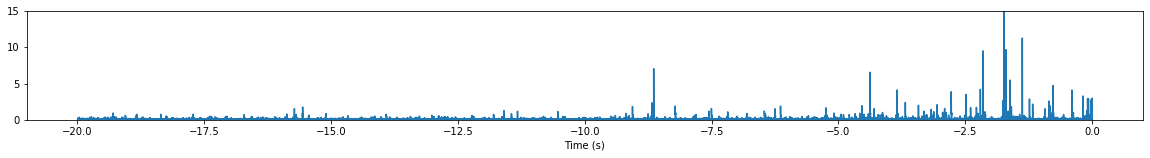

In [16]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0,15])
#plt.xlim([-15,0])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

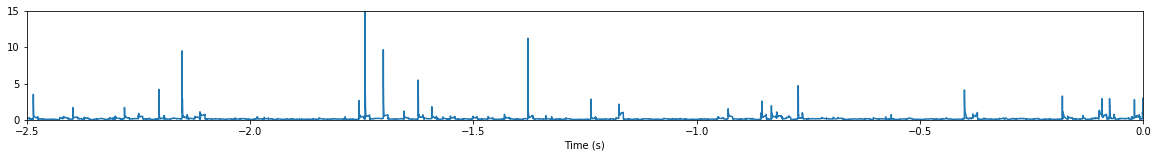

In [18]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0,15])
plt.xlim([-2.5,0])
plt.xlabel("Time (s)")

## 1.2 Window size: 100ms; step = 100us

In [5]:
X_train, train_time = generate_data_all_sensors("./data/Ramp4/", time_range = (-450, -350), window = 10000, step = 10)
X_test, test_time = generate_data_all_sensors("./data/Ramp4/", time_range = (-20, 0), window = 10000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (999000, 20)
X_test's shape:  (199000, 20)


In [6]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(15, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(10,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(7,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(15,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 15)                165       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                320       
Total params: 1,117
Trainable params: 1,117
Non-trainable params: 0
________________________

In [7]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=2000

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 899100 samples, validate on 99900 samples
Epoch 1/50
899100/899100 [==============================] - 8s 9us/step - loss: 57.5116 - val_loss: 0.4514
Epoch 2/50
899100/899100 [==============================] - 7s 8us/step - loss: 0.3322 - val_loss: 0.1177
Epoch 3/50
899100/899100 [==============================] - 7s 7us/step - loss: 0.1953 - val_loss: 0.0916
Epoch 4/50
899100/899100 [==============================] - 7s 8us/step - loss: 0.1740 - val_loss: 0.0800
Epoch 5/50
899100/899100 [==============================] - 7s 8us/step - loss: 0.1627 - val_loss: 0.0735
Epoch 6/50
899100/899100 [==============================] - 7s 8us/step - loss: 0.1558 - val_loss: 0.0707
Epoch 7/50
899100/899100 [==============================] - 7s 8us/step - loss: 0.1511 - val_loss: 0.0683
Epoch 8/50
899100/899100 [==============================] - 7s 7us/step - loss: 0.1478 - val_loss: 0.0690
Epoch 9/50
899100/899100 [==============================] - 7s 8us/step - loss: 0.1460 - val_loss: 0

In [8]:
model.save("./models/All-Ramp4-100mswin-100usstep.h5")

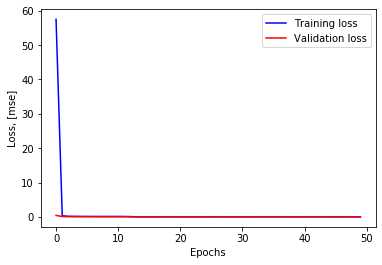

In [9]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

In [10]:
X_pred = model.predict(np.array(X_train))
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

Text(0.5, 0, 'Time (s)')

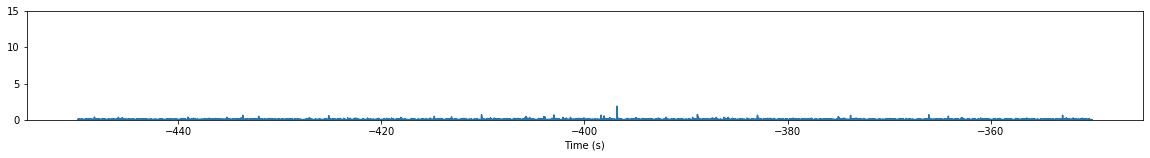

In [11]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0,15])
plt.xlabel("Time (s)")

In [12]:
X_pred_test = model.predict(np.array(X_test))
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

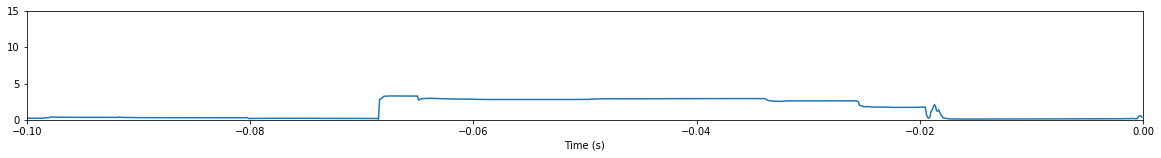

In [15]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0,15])
plt.xlim([-100e-3,0])
plt.xlabel("Time (s)")

## 3 Window size: 1s; step = 100us

In [6]:
X_train, train_time = generate_data_all_sensors("./data/Ramp4/", time_range = (-450, -350), window = 100000, step = 10)
X_test, test_time = generate_data_all_sensors("./data/Ramp4/", time_range = (-20, 0), window = 100000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (990000, 20)
X_test's shape:  (190000, 20)


In [7]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(15, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(10,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(7,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(15,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 15)                165       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                320       
Total params: 1,117
Trainable params: 1,117
Non-trainable params: 0
________________________

In [8]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=2000

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 891000 samples, validate on 99000 samples
Epoch 1/50
891000/891000 [==============================] - 8s 9us/step - loss: 136.3159 - val_loss: 2.4114
Epoch 2/50
891000/891000 [==============================] - 8s 9us/step - loss: 1.0075 - val_loss: 0.1590
Epoch 3/50
891000/891000 [==============================] - 7s 8us/step - loss: 0.3527 - val_loss: 0.0928
Epoch 4/50
891000/891000 [==============================] - 7s 8us/step - loss: 0.3132 - val_loss: 0.0665
Epoch 5/50
891000/891000 [==============================] - 7s 8us/step - loss: 0.3000 - val_loss: 0.0794
Epoch 6/50
891000/891000 [==============================] - 7s 8us/step - loss: 0.2893 - val_loss: 0.0619
Epoch 7/50
891000/891000 [==============================] - 7s 8us/step - loss: 0.2797 - val_loss: 0.0859
Epoch 8/50
891000/891000 [==============================] - 7s 8us/step - loss: 0.2604 - val_loss: 0.0512
Epoch 9/50
891000/891000 [==============================] - 6s 7us/step - loss: 0.2220 - val_loss: 

In [9]:
model.save("./models/All-Ramp4-1swin-100usstep.h5")

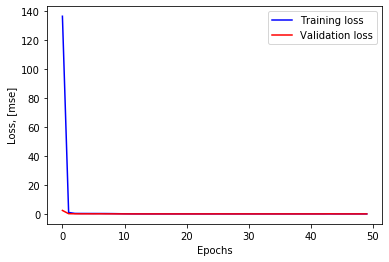

In [10]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

In [11]:
X_pred = model.predict(np.array(X_train))
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [12]:
X_pred_test = model.predict(np.array(X_test))
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

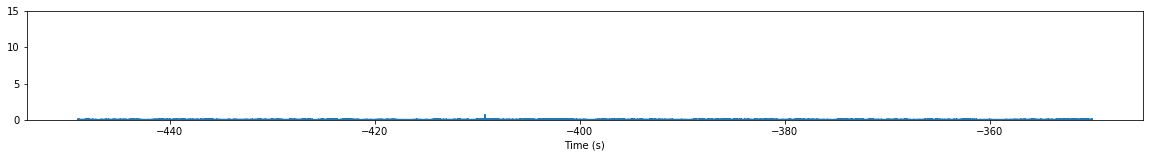

In [13]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0,15])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

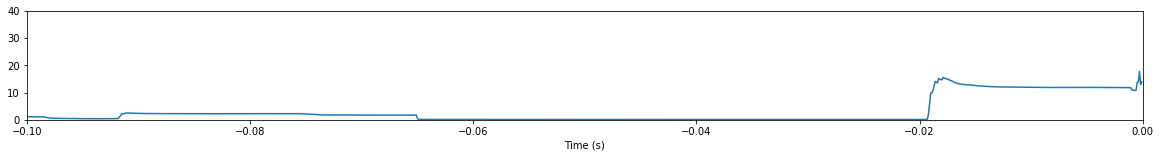

In [20]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0,40])
plt.xlim([-100e-3,0])
plt.xlabel("Time (s)")

## 4 Window size: 2s; step = 100us

In [5]:
X_train, train_time = generate_data_all_sensors("./data/Ramp4/", time_range = (-450, -350), window = 200000, step = 10)
X_test, test_time = generate_data_all_sensors("./data/Ramp4/", time_range = (-20, 0), window = 200000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (980000, 20)
X_test's shape:  (180000, 20)


In [6]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(15, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(10,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(7,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(15,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 15)                165       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                320       
Total params: 1,117
Trainable params: 1,117
Non-trainable params: 0
________________________

In [7]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=2000

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 882000 samples, validate on 98000 samples
Epoch 1/50
882000/882000 [==============================] - 8s 9us/step - loss: 195.7454 - val_loss: 48.7912
Epoch 2/50
882000/882000 [==============================] - 7s 7us/step - loss: 41.0780 - val_loss: 52.7953
Epoch 3/50
882000/882000 [==============================] - 6s 7us/step - loss: 38.4415 - val_loss: 50.6189
Epoch 4/50
882000/882000 [==============================] - 7s 8us/step - loss: 37.0514 - val_loss: 51.8642
Epoch 5/50
882000/882000 [==============================] - 7s 8us/step - loss: 36.2523 - val_loss: 52.0213
Epoch 6/50
882000/882000 [==============================] - 7s 7us/step - loss: 34.7882 - val_loss: 52.0909
Epoch 7/50
882000/882000 [==============================] - 7s 8us/step - loss: 31.8220 - val_loss: 46.9779
Epoch 8/50
882000/882000 [==============================] - 7s 8us/step - loss: 27.2794 - val_loss: 14.6833
Epoch 9/50
882000/882000 [==============================] - 7s 8us/step - loss: 7.24

In [8]:
model.save("./models/All-Ramp4-2swin-100usstep.h5")

In [9]:
X_pred = model.predict(np.array(X_train))
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [10]:
X_pred_test = model.predict(np.array(X_test))
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

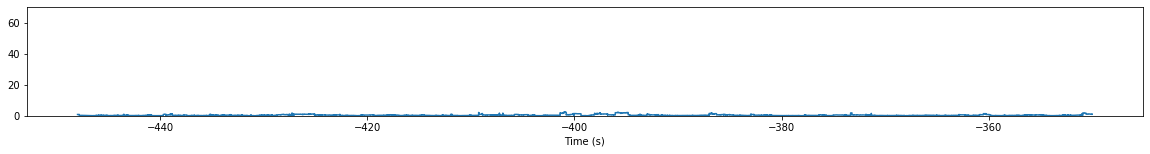

In [19]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0,70])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

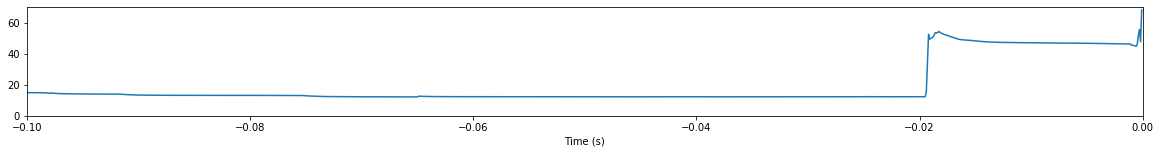

In [22]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0,70])
plt.xlim([-100e-3,0])
plt.xlabel("Time (s)")